In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [3]:
data = pd.read_excel('online_retail_II.xlsx')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [6]:
data.dropna(subset=["Customer ID"], inplace=True)


data["TotalPrice"] = data["Quantity"] * data["Price"]

In [7]:
customer_data = data.groupby("Customer ID").agg({
    "Invoice": "nunique",     
    "Quantity": "sum",         
    "TotalPrice": "sum"        
}).rename(columns={
    "Invoice": "TransactionCount",
    "Quantity": "TotalQuantity",
    "TotalPrice": "TotalSpend"
}).reset_index()


In [8]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

customer_data = remove_outliers(customer_data, ["TransactionCount", "TotalQuantity", "TotalSpend"])

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[["TransactionCount", "TotalQuantity", "TotalSpend"]])

In [10]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

C:\Users\rveab\PYthon\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rveab\PYthon\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rveab\PYthon\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rveab\PYthon\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\rveab\PYthon\lib\site-packages\sklearn\cluster\_kmeans.py:8

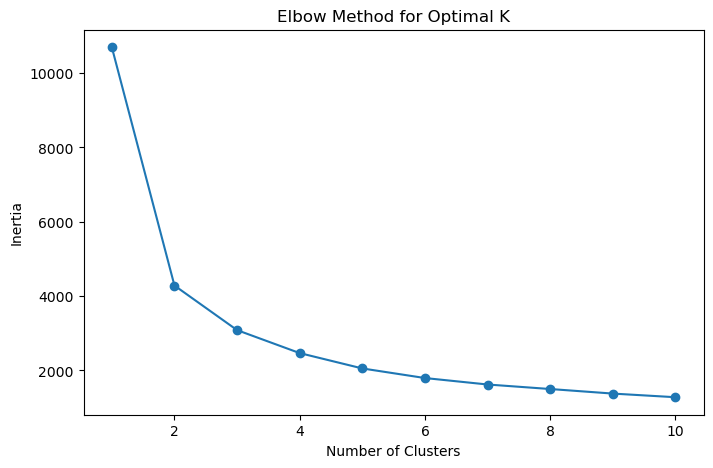

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [12]:
optimal_k = 4 
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_features)

C:\Users\rveab\PYthon\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

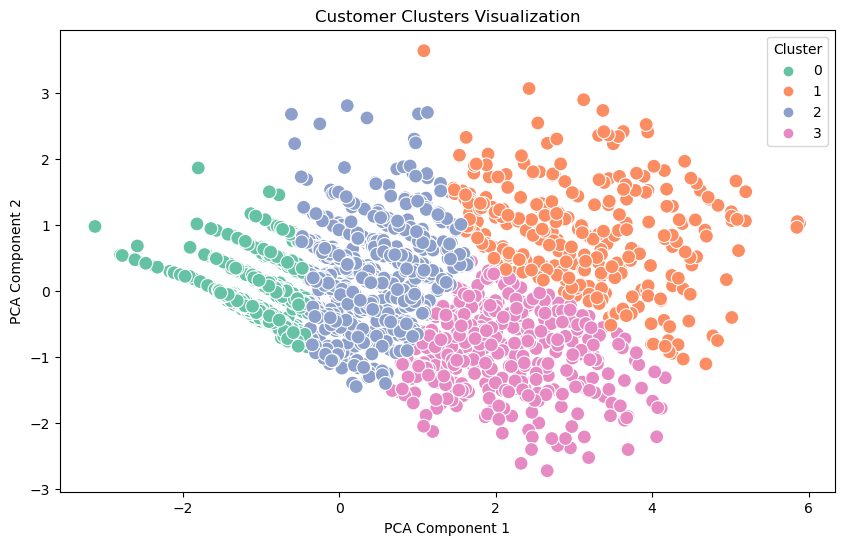

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=customer_data["Cluster"], palette="Set2", s=100)
plt.title("Customer Clusters Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [15]:
cluster_summary = customer_data.groupby("Cluster").agg({
    "TransactionCount": "mean",
    "TotalQuantity": "mean",
    "TotalSpend": "mean"
}).rename(columns={
    "TransactionCount": "AvgTransactions",
    "TotalQuantity": "AvgQuantity",
    "TotalSpend": "AvgSpend"
})

print("\nCluster Summary:")
print(cluster_summary)

customer_data.to_csv("customer_clusters_built_in.csv", index=False)


Cluster Summary:
         AvgTransactions  AvgQuantity     AvgSpend
Cluster                                           
0               1.465686   144.864924   256.538073
1               8.800000   901.507937  1648.820705
2               3.670397   427.241099   774.593256
3               3.925754   994.245940  1543.299606
